<a href="https://colab.research.google.com/github/Mehrnoushhk/DeepLearning/blob/master/PinAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import datetime

In [2]:
# Reading data
url= 'https://raw.githubusercontent.com/Mehrnoushhk/DeepLearning/master/GBPUSDm30.csv'
data= pd.read_csv(url) 
data.columns= ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume'] 


In [3]:
# Converting Time and Date to proper DateTime format
#%%time
numericIndex= []
for i in range(0, data.shape[0]):
  temptext= data.iloc[i, 0]
  a= int(temptext[0:4])
  b= int(temptext[5:7])
  c= int(temptext[8:])
  temptime= data.iloc[i, 1]
  h= int(temptime[:-3])
  m= int(temptime[3:])
  tempdate= datetime.datetime(year= a, month= b, day= c, hour= h, minute= m, second= 0)
  data.iloc[i,0]= tempdate
  numericIndex.append(i)

In [4]:
del data['Time']
data.set_index('Date', inplace= True)
data.index= pd.to_datetime(data.index)
data['ID']= numericIndex

In [ ]:
data.to_csv('GBPm30.csv')

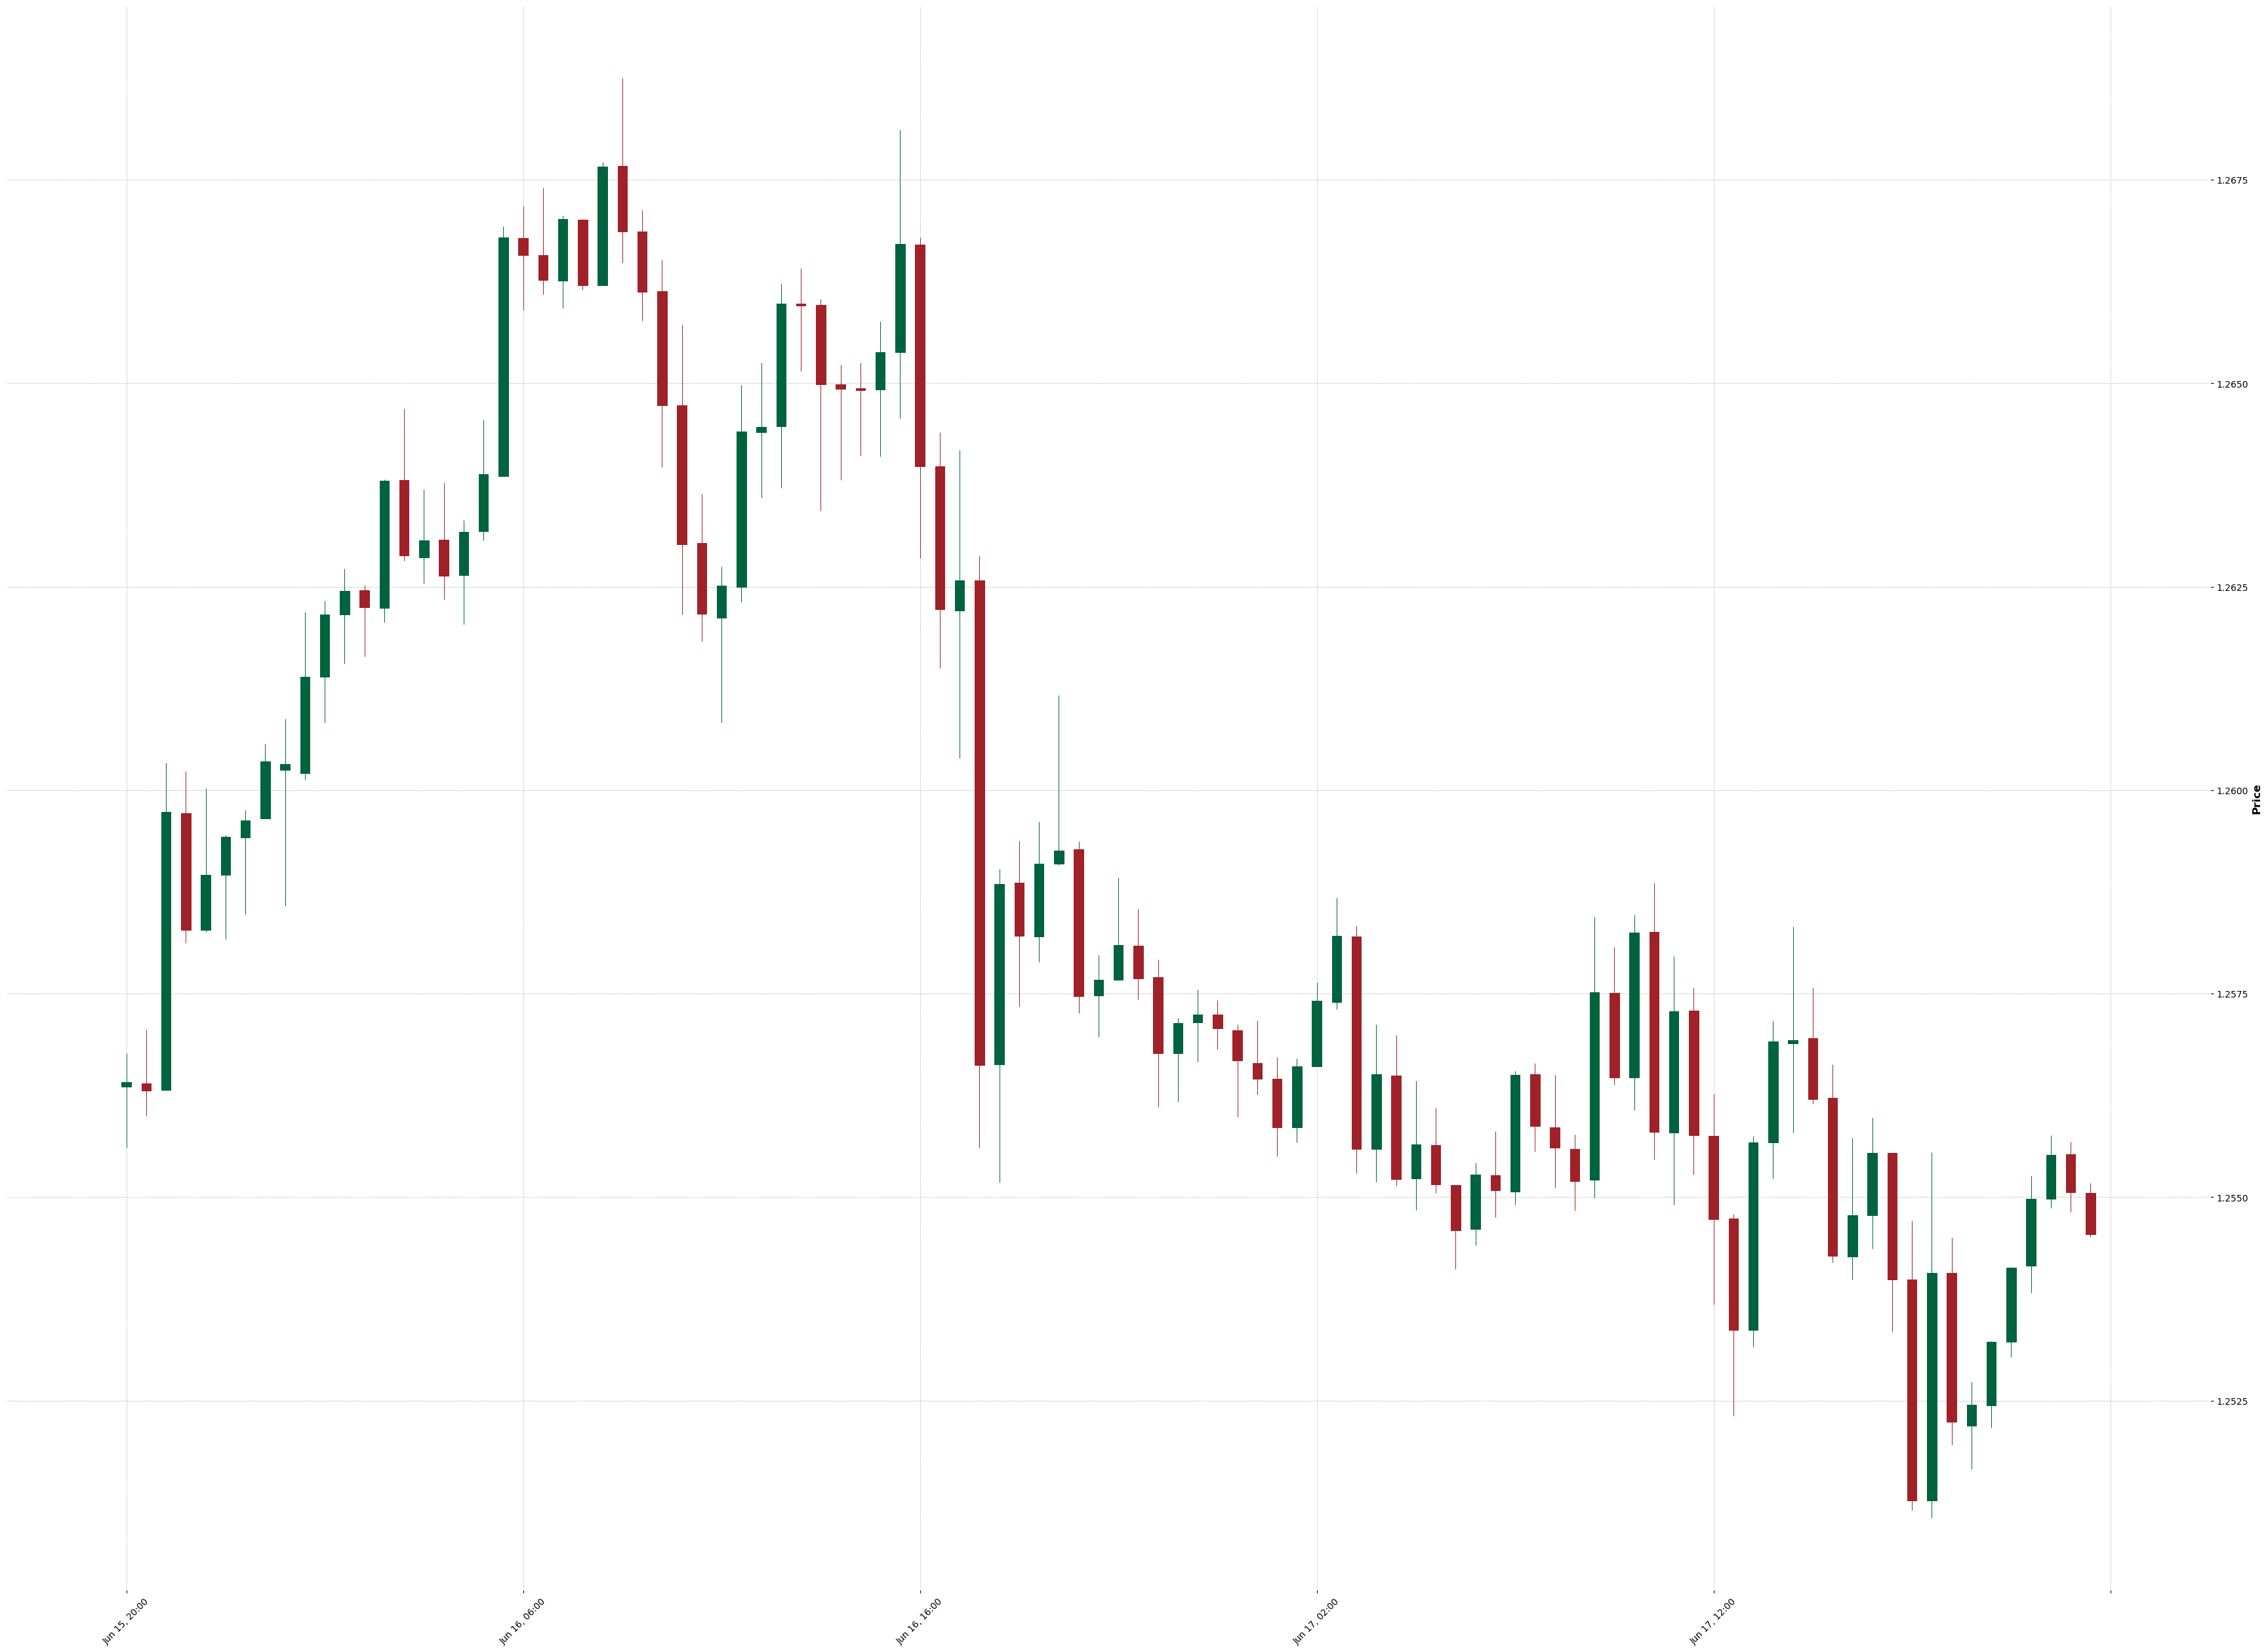

In [5]:
#!pip install mplfinance
import mplfinance as mpl
mpl.plot(data.iloc[data.shape[0]-100: data.shape[0],:], type= 'candle', style= 'charles', figscale= 6) # , savefig= '/content/Plots/fig01.png'

In [6]:
# Define Local Maximum
def localMax(data, step):
  isMax= []
  maxValue= []
  for i in range(0, step):
    isMax.append(False)
    maxValue.append(np.nan)
  for i in range(step, data.shape[0]-step):
    tempOptimal= True
    tempValue= data.iloc[i, 1]
    for j in range(1, step+1):
      if (data.iloc[i,1] < data.iloc[i-j,1]) or (data.iloc[i,1] < data.iloc[i+j, 1]):
        tempOptimal= False
        tempValue= np.nan
    isMax.append(tempOptimal)
    maxValue.append(tempValue)
  for i in range(0, step):
    isMax.append(False)
    maxValue.append(np.nan)  
  return isMax, maxValue


# Define Local Minimum
def localMin(data, step):
  isMin= []
  minValue= []
  for i in range(0, step):
    isMin.append(False)
    minValue.append(np.nan)
  for i in range(step, data.shape[0]-step):
    tempOptimal= True
    tempValue= data.iloc[i, 2]
    for j in range(1, step+1):
      if (data.iloc[i,2] > data.iloc[i-j,2]) or (data.iloc[i,2] > data.iloc[i+j, 2]):
        tempOptimal= False
        tempValue= np.nan
    isMin.append(tempOptimal)
    minValue.append(tempValue)
  for i in range(0, step):
    isMin.append(False)
    minValue.append(np.nan)  
  return isMin, minValue

In [7]:
#%%time
dataMax, dataMaxValue= localMax(data, 4)
dataMin, dataMinValue= localMin(data, 4)

In [8]:
data['isMax']= dataMax
data['maxValue']= dataMaxValue
data['isMin']= dataMin
data['minValue']= dataMinValue

In [9]:
minMax= pd.DataFrame(list(zip(dataMinValue, dataMaxValue)), columns=['min', 'Max'])

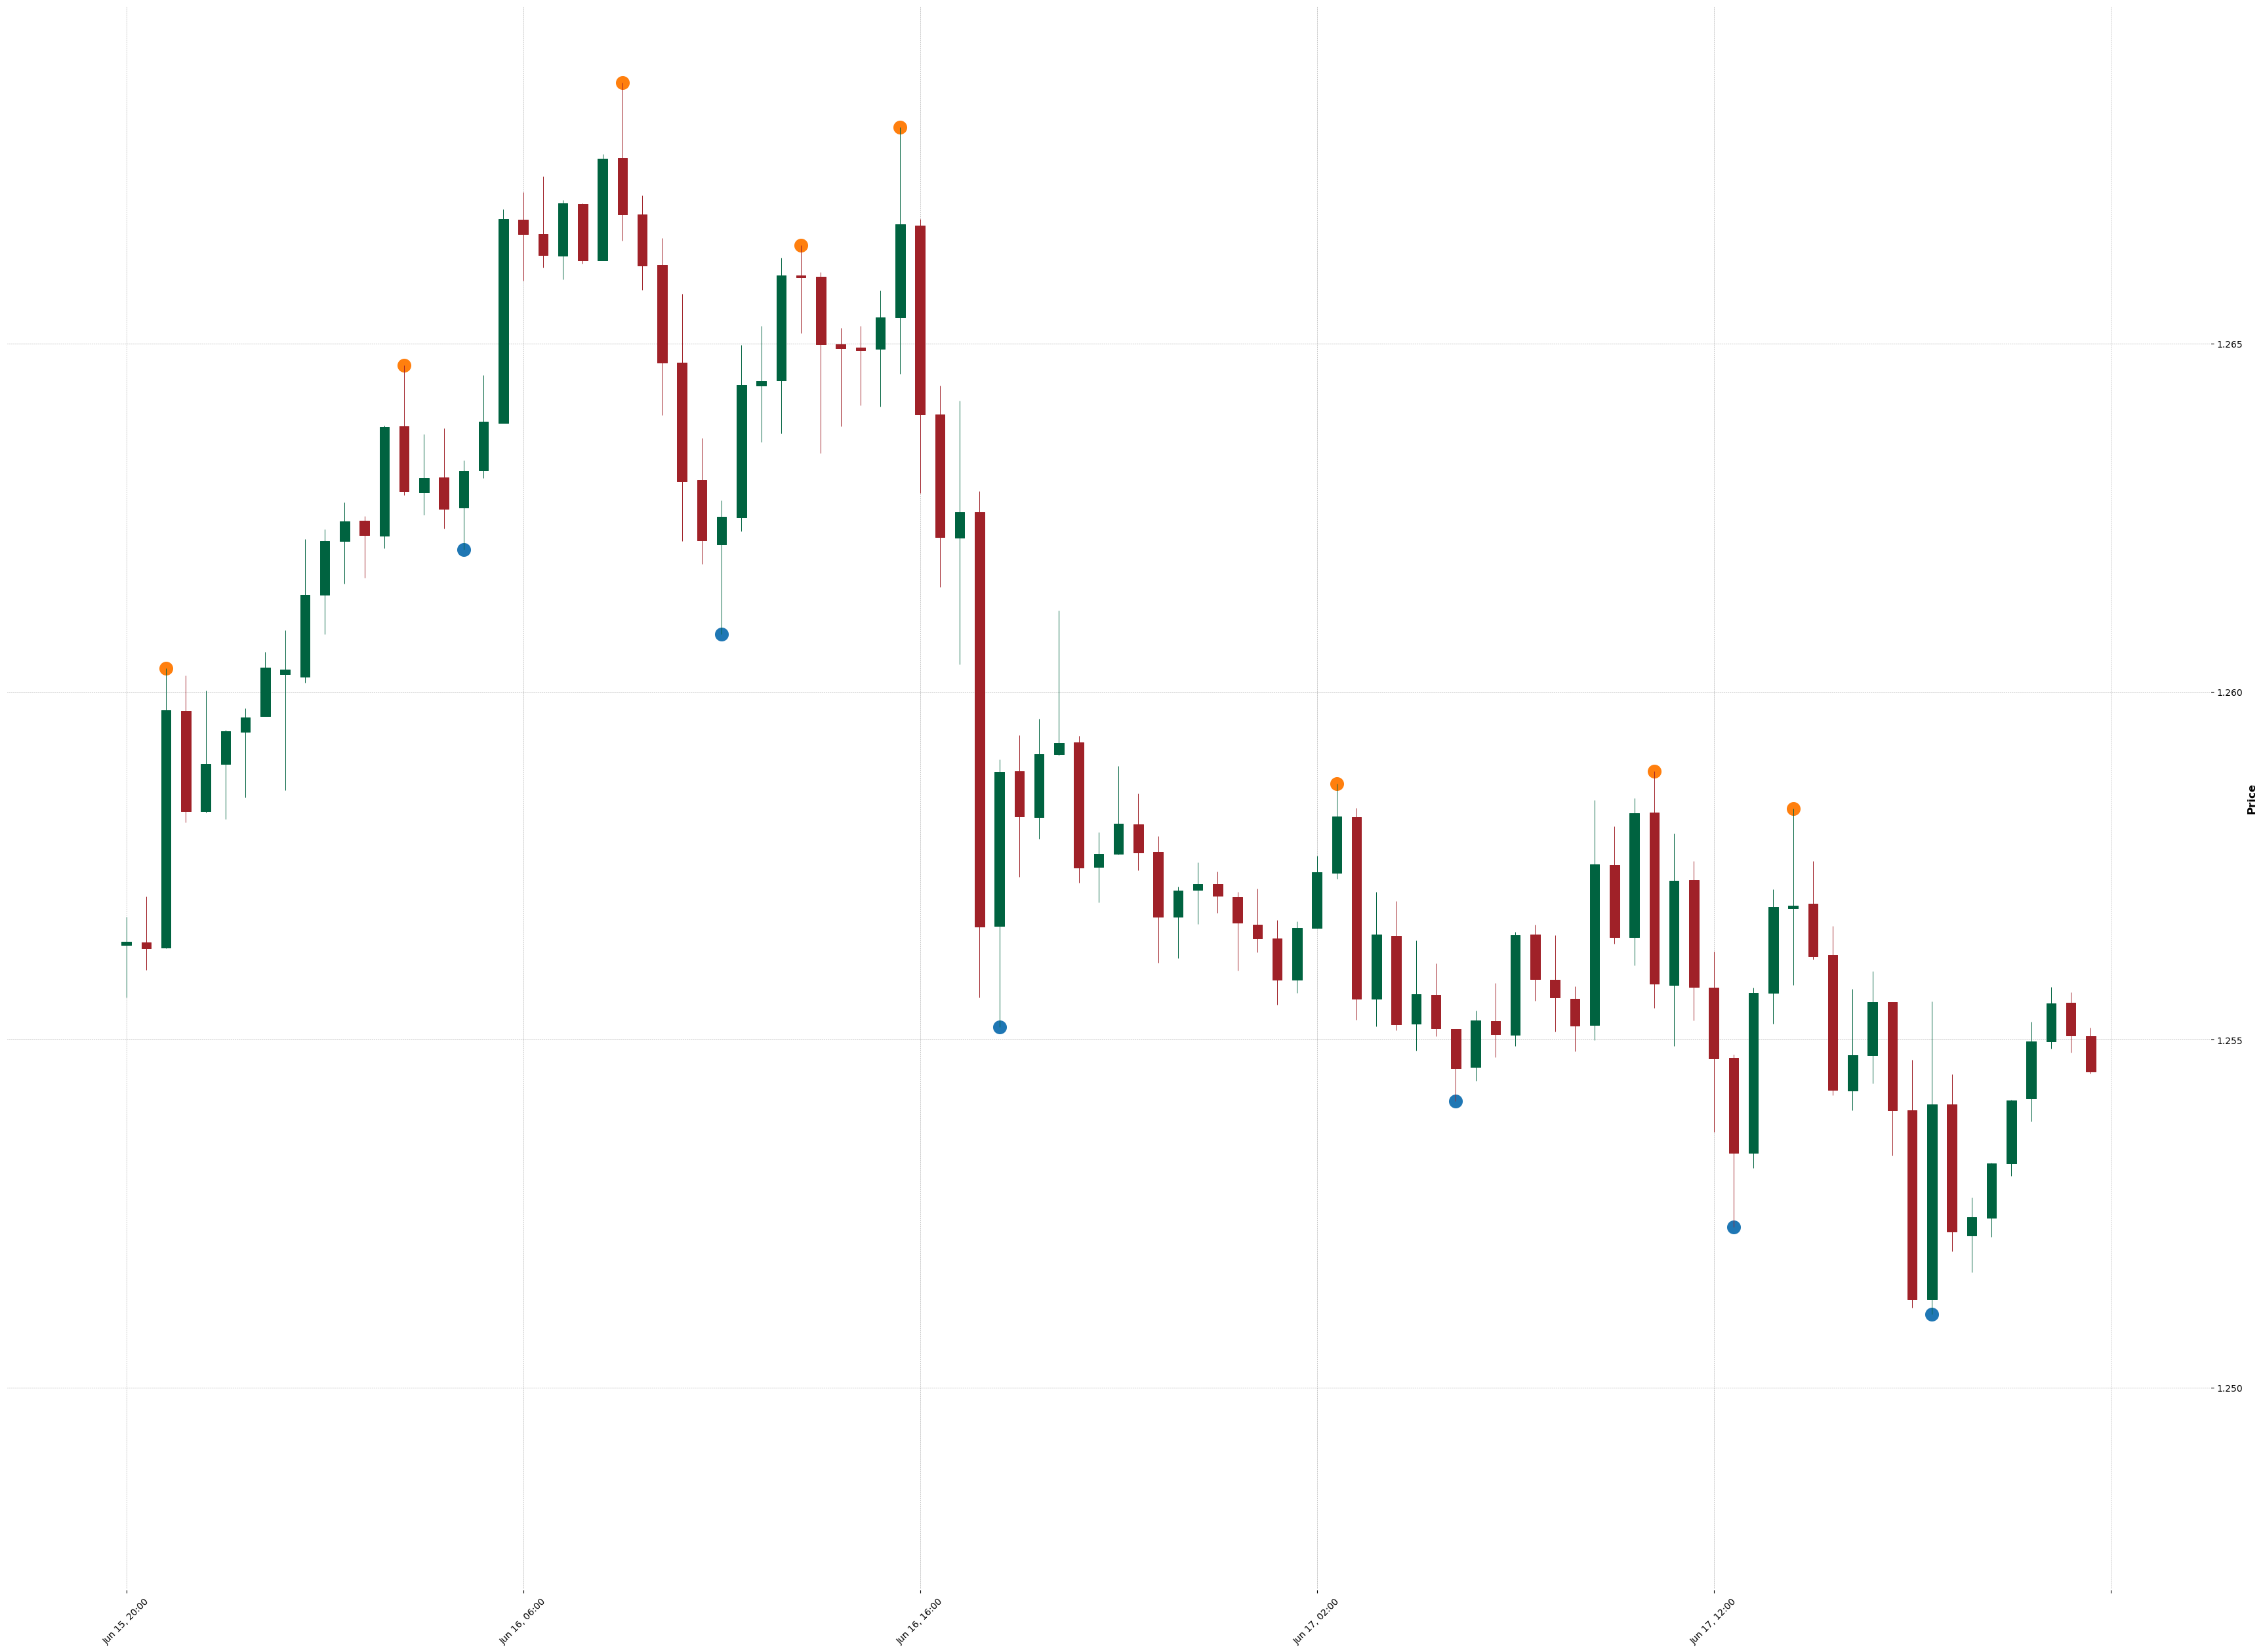

In [10]:
adp= mpl.make_addplot(minMax[len(minMax)-100:], type= 'scatter', markersize= 200)
mpl.plot(data.iloc[data.shape[0]-100: data.shape[0],:], type= 'candle', style= 'charles', figscale= 6, addplot= adp)

In [57]:
isMaxid= 6
maxValueid= 7
isMinid= 8
minValueid= 9
trendid= 10

In [62]:
# I want to see if after a high the trend becom downward or not so first we should examine the next high
def nextHigh(data, i):
    nextHighValue= data.iloc[i, maxValueid]
    for j in range(i+1, data.shape[0]):
        if data.iloc[j, isMaxid]== True:
            nextHighValue= data.iloc[j, maxValueid]
            break
    return nextHighValue

def nextLow(data, i):
    nextLowValue= data.iloc[i, minValueid]
    for j in range(i+1, data.shape[0]):
        if data.iloc[j, isMinid]== True:
            nextLowValue= data.iloc[j, minValueid]
            break
    return nextLowValue

def previousHigh(data, i):
    previousHighValue= data.iloc[i, maxValueid]
    j= i-1
    while j>= 0:
        if data.iloc[j, isMaxid]== True:
            previousHighValue= data.iloc[j, maxValueid]
            break
        j= j- 1
    return previousHighValue

def previousLow(data, i):
    previousLowValue= data.iloc[i, minValueid]
    j= i-1
    while j>= 0:
        if data.iloc[j, isMinid]== True:
            previousLowValue= data.iloc[j, minValueid]
            break
        j= j-1
    return previousLowValue


In [72]:
Trend= np.empty((data.shape[0], 1))
Trend[:]= np.nan
Trend= list(Trend)
data['Trend']= Trend

In [73]:
# Check the trend after an optimal point
def trendDetector(data, i):

    if data.iloc[i, isMaxid] == True:
        if (nextHigh(data, i) < data.iloc[i, maxValueid]) and (nextLow(data, i) < previousLow(data,i)):
            data.iloc[i, trendid]= data.iloc[i, maxValueid]
    if data.iloc[i, isMinid] == True:
        if (nextLow(data, i) > data.iloc[i, minValueid]) and(nextHigh(data, i) > previousHigh(data, i)):
            data.iloc[i, trendid]= data.iloc[i, minValueid]

In [ ]:
"""
    trend= 'none'
    if data.iloc[i, isMaxid]== True:
        nextHighValue= nextHigh(data, i)
        previousLowValue= previousLow(data, i)
        nextLowValue= nextLow(data, i)
        if (nextHighValue < data.iloc[i, maxValueid]) and (nextLowValue < previousLowValue):
            trend= 'down'
        else:
            trend= 'test'
    return trend
"""

In [74]:
%%time
for i in range(data.shape[0]-100, data.shape[0]):
    trendDetector(data, i)

Wall time: 43 ms


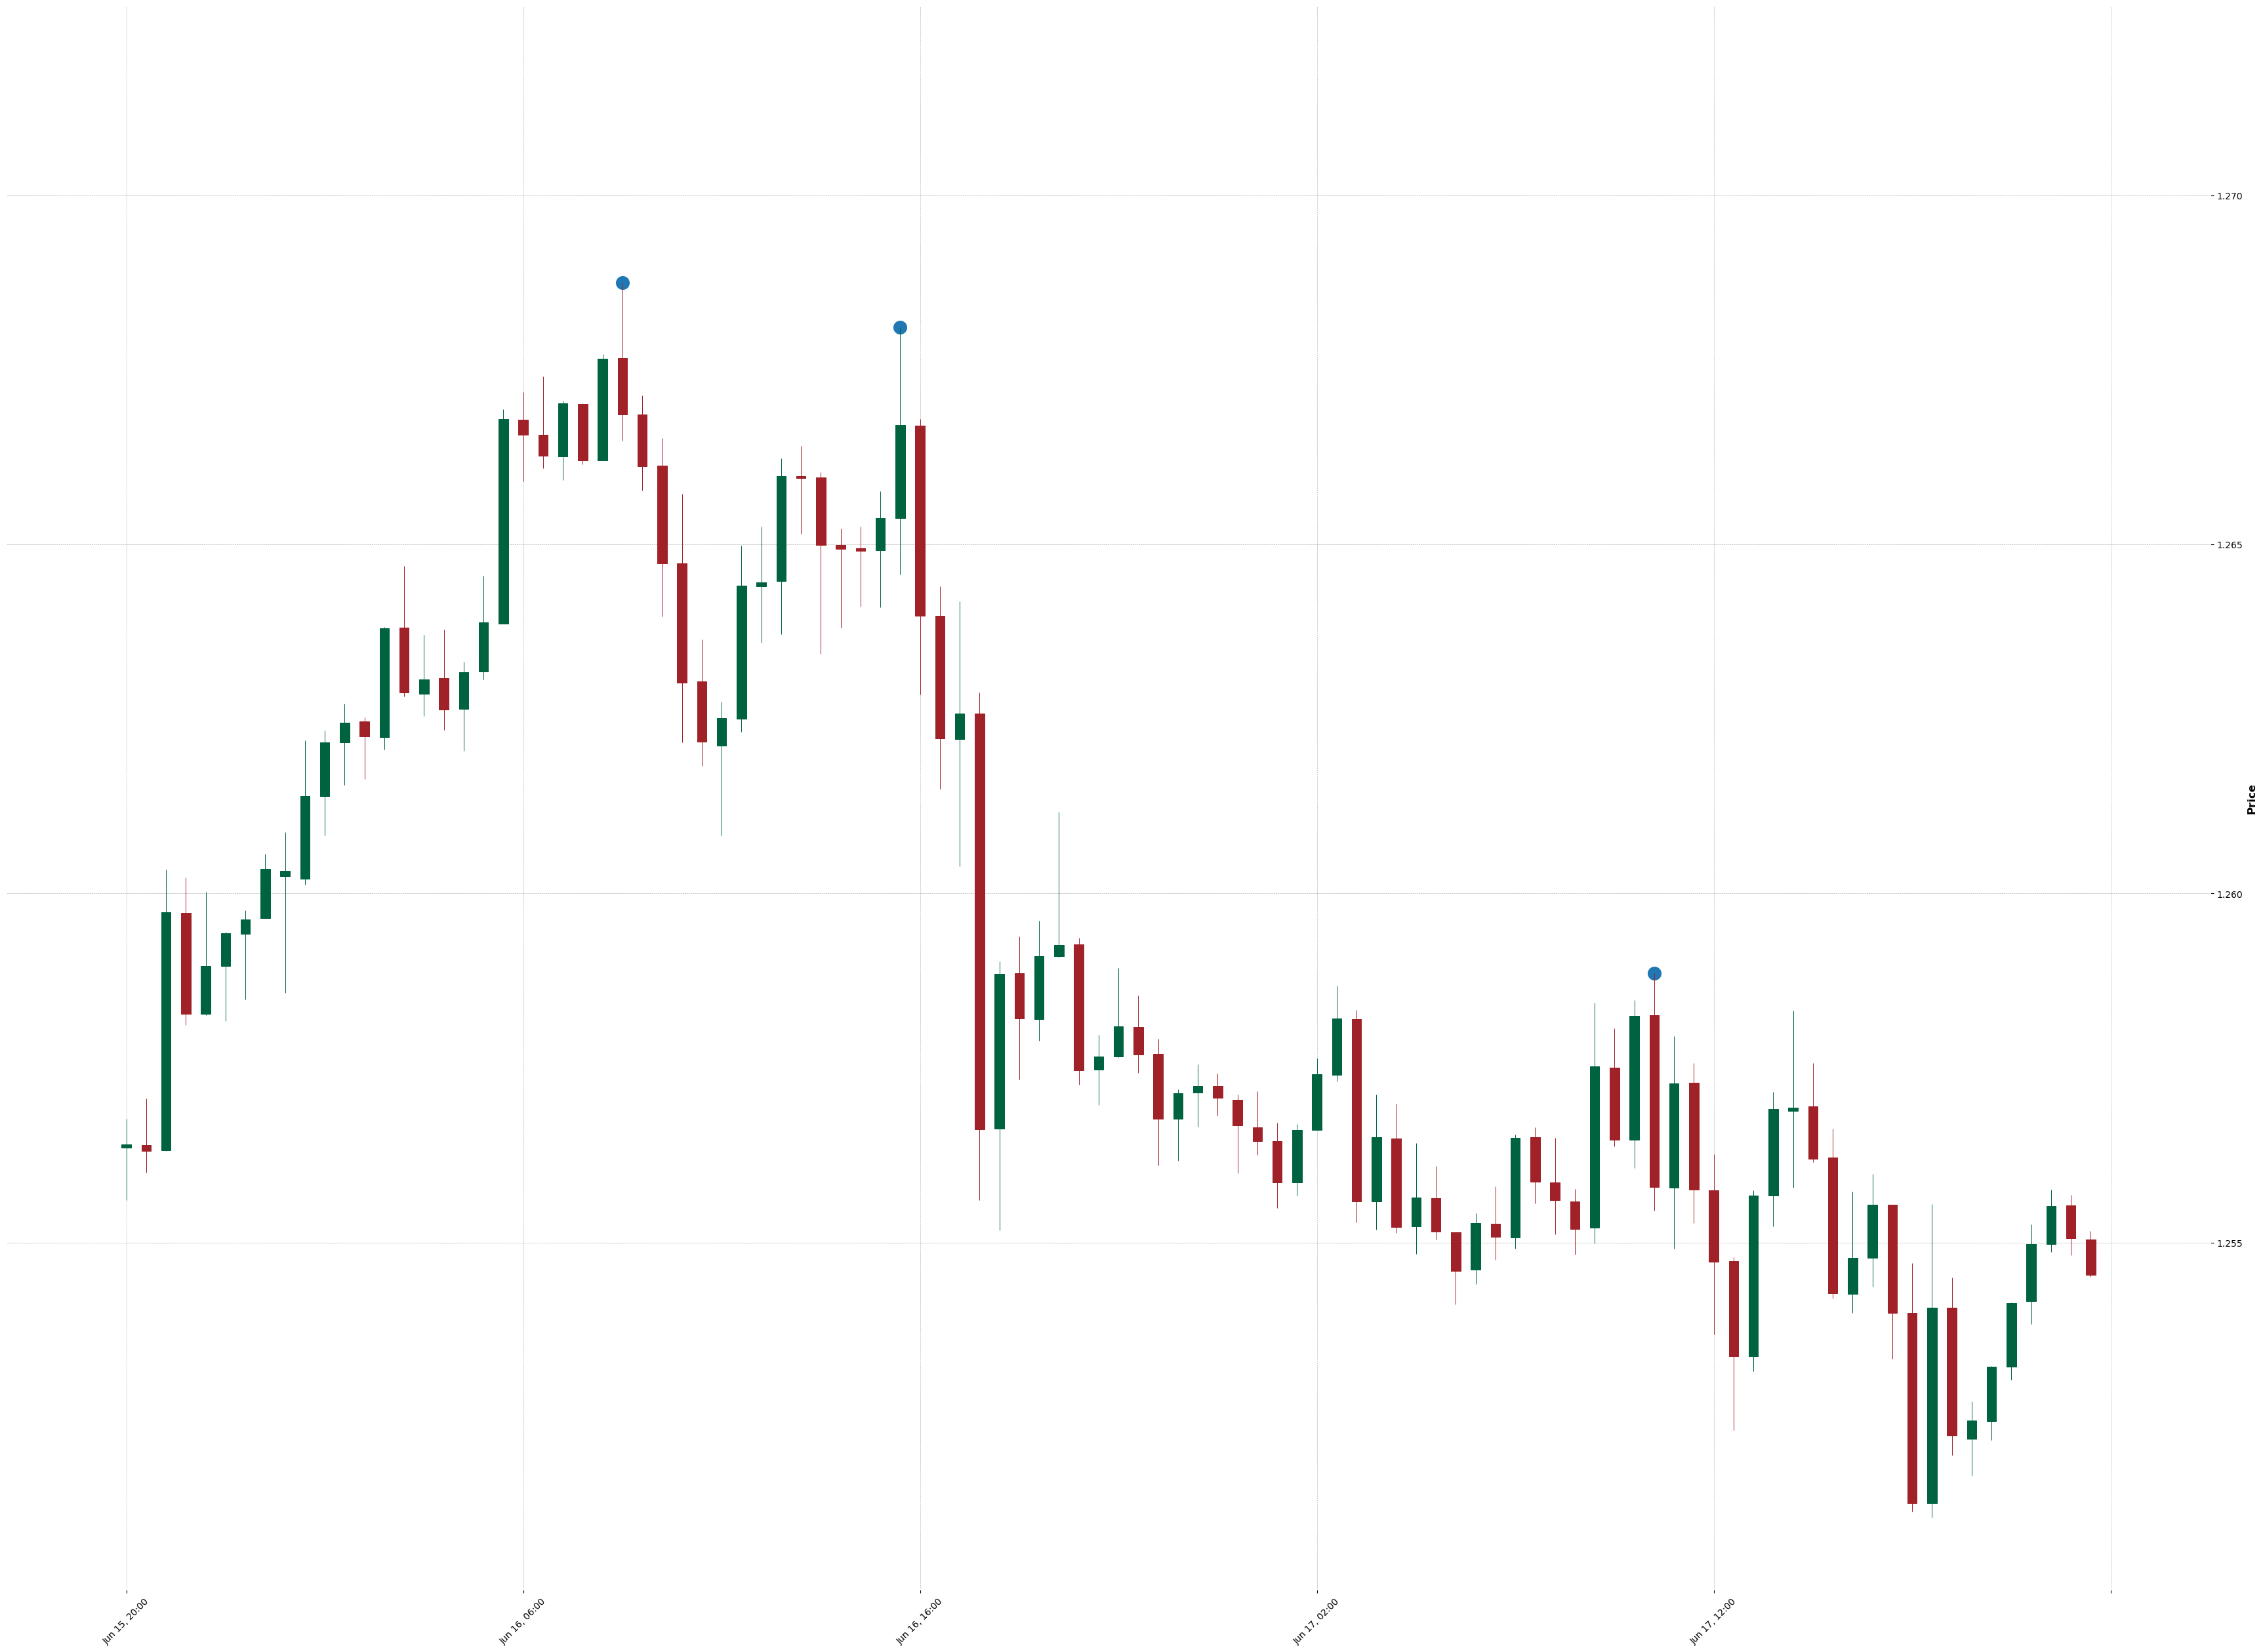

In [76]:
adp2= mpl.make_addplot(data.iloc[data.shape[0]-100:, trendid], type= 'scatter', markersize= 200)
mpl.plot(data.iloc[data.shape[0]-100: data.shape[0],:], type= 'candle', style= 'charles', figscale= 6, addplot= adp2)

In [ ]:
#The simplest performance meyric
%%time
def performance(x, y):
  perf= (y- x)/x
  return perf
upPerformance= []
downPerformance= []
for i in range(0, data.shape[0]-1-5):
  upTemp= performance(data.iloc[i, 3], data.iloc[i+5, 1])
  upPerformance.append(upTemp)
  downTemp= performance(data.iloc[i, 3], data.iloc[i+5, 2])
  downPerformance.append(downTemp)

#data['Up']= upPerformance
#data['Down']= downPerformance
 


CPU times: user 33.8 s, sys: 7.6 ms, total: 33.9 s
Wall time: 33.9 s


In [ ]:
# Function to search for Pinbar


In [ ]:
# Function to see what happens after 




In [ ]:
# Create LSTM model




In [ ]:
# Feed data to model

